# Charm-tagging working points

In [1]:
import os
import ROOT
import getpass
import uproot
import awkward
import matplotlib.pyplot as plt
import pprint
import numpy as np
from tqdm import tqdm,tqdm_notebook
from itertools import permutations
from IPython.display import HTML, display
from array import array

Welcome to JupyROOT 6.14/09


### Configuration parameters

In [2]:
a = os.listdir("/eos/cms/store/group/phys_btag/performance/UL18/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8_RunIISummer19UL18MiniAOD-106X_upgrade2018_realistic_v11_L1v1/hadronic/")
#a

In [3]:
year_label = "2018UL"
sample = "fully-hadronic t#bar{t}"

min_pt = 20
max_abs_eta = 2.5


nfiles = 10


#files_path = ['root://xrootd-cms.infn.it//store/user/smoortga/BTagServiceWork/CTaggerWPs_2017_UltraLegacy/QCD_Pt_80to120_TuneCP5_13TeV_pythia8_RunIISummer19UL17MiniAOD-106X_mc2017_realistic_v6-v2_MINIAODSIM/QCD_Pt_80to120_TuneCP5_13TeV_pythia8/crab_BTagAnalyzer_CTagWP_2017_UltraLegacy/200116_133349/0000/JetTree_mc_%i.root'%idx for idx in range(1,nfiles+1)]
files_path = ['root://xrootd-cms.infn.it//eos/cms/store/group/phys_btag/performance/UL18/MC/TTToHadronic_TuneCP5_13TeV-powheg-pythia8_RunIISummer19UL18MiniAOD-106X_upgrade2018_realistic_v11_L1v1/hadronic/%s'%a[idx] for idx in range(1,nfiles+1)]

tree_directory = 'btagana/ttree'
branches=["nJet",
          "Jet_pt",
          "Jet_eta",
          'Jet_flavourCleaned',
          'Jet_tightID',
          #'Jet_pileup_looseID',
          'Jet_DeepFlavourBDisc',
          'Jet_DeepFlavourCvsLDisc',
          'Jet_DeepFlavourCvsBDisc',
          'Jet_DeepCSVBDisc',
          'Jet_DeepCSVCvsLDisc',
          'Jet_DeepCSVCvsBDisc',
         ]
taggers = ['Jet_DeepFlavourBDisc',
           'Jet_DeepFlavourCvsLDisc',
           'Jet_DeepFlavourCvsBDisc',
           'Jet_DeepCSVBDisc',
           'Jet_DeepCSVCvsLDisc',
           'Jet_DeepCSVCvsBDisc',
          ]
flavours = ["b","c","l"]

# working points
min_val = 0
max_val = 1
precision = 0.0001
max_niter = 500
wp_arr = [ # tager mistag rates: [mistag_eff_light,mistag_eff_b]
    ["loose",[0.9,0.35]],
    ["medium",[0.25,0.25]],
    ["tight",[0.03,0.20]]
]

### Helper functions

In [4]:
def tchain(fpath,tpath,branchlist,steps=None):    
    return uproot.tree.iterate(path=fpath,
                            treepath=tpath,
                            branches=branchlist,
                            entrysteps=steps)

### Grid certificate (optional)

In [5]:
# password = getpass.getpass("Enter Password for grid certificate: ")
# proxy_cmd = "voms-proxy-init --rfc --voms cms -valid 192:00"
# os.system('echo %s | %s' % (password, proxy_cmd))

### Get info from trees

In [6]:
trees = tchain(files_path,tree_directory,branches) 

discriminator_dict = {}
for tagger in taggers:
    discriminator_dict[tagger]={}
    discriminator_dict["Jet_pt"]={}
    discriminator_dict["Jet_eta"]={}
    #discriminator_dict["nPV"]={}
    for flav in flavours:
        discriminator_dict[tagger][flav]=[]
        discriminator_dict["Jet_pt"][flav]=[]
        discriminator_dict["Jet_eta"][flav]=[]
        #discriminator_dict["nPV"][flav]=[]

        
# for branches in tqdm(trees,
#                     total=n_subtrees,
#                     desc="Progress"):

nevents = 0

for idx,branches in enumerate(trees): 
    print "running tree number %i: %i events processed"%(idx,nevents)
    nevents += len(branches['nJet'])
    #plt.hist(branches['Jet_flavourCleaned'].flatten())
    eta_mask = abs(branches['Jet_eta']) < max_abs_eta
    pt_mask = branches['Jet_pt'] > min_pt
    jetID_mask = branches['Jet_tightID'] == 1
    flavour_mask={}
    for flav in flavours:
        if flav == "b": flavour_mask[flav] = branches['Jet_flavourCleaned'] == 5
        elif flav == "c": flavour_mask[flav] = branches['Jet_flavourCleaned'] == 4
        elif flav == "l": flavour_mask[flav] = (branches['Jet_flavourCleaned'] >= 0) * (branches['Jet_flavourCleaned'] != 4) * (branches['Jet_flavourCleaned'] != 5)
    
    
    
    for tagger in taggers:
        for flav in flavours:
            array_tmp = np.asarray(branches[tagger][eta_mask & pt_mask & jetID_mask & flavour_mask[flav]].flatten())
            discriminator_dict[tagger][flav] = np.concatenate((discriminator_dict[tagger][flav],array_tmp))
    
    for flav in flavours:
        array_tmp_pt = np.asarray(branches["Jet_pt"][eta_mask & pt_mask & jetID_mask & flavour_mask[flav]].flatten())
        discriminator_dict["Jet_pt"][flav] = np.concatenate((discriminator_dict["Jet_pt"][flav],array_tmp_pt))
            
        array_tmp_eta = np.asarray(branches["Jet_eta"][eta_mask & pt_mask & jetID_mask & flavour_mask[flav]].flatten())
        discriminator_dict["Jet_eta"][flav] = np.concatenate((discriminator_dict["Jet_eta"][flav],array_tmp_eta))
            
            

#pprint.pprint(discriminator_dict)
print "Processed %i events"%nevents

running tree number 0: 0 events processed
running tree number 1: 15059 events processed
running tree number 2: 30118 events processed
running tree number 3: 36000 events processed
running tree number 4: 50999 events processed
running tree number 5: 65998 events processed
running tree number 6: 80997 events processed
running tree number 7: 95996 events processed
running tree number 8: 105600 events processed
running tree number 9: 120669 events processed
running tree number 10: 135738 events processed
running tree number 11: 141600 events processed
running tree number 12: 156633 events processed
running tree number 13: 171666 events processed
running tree number 14: 186699 events processed
running tree number 15: 201732 events processed
running tree number 16: 211200 events processed
running tree number 17: 226236 events processed
running tree number 18: 241272 events processed
running tree number 19: 254400 events processed
running tree number 20: 269458 events processed
running tree n

### Calculating working points according to some predefined mistags

In [7]:
out_dict = {}

def distance(current,target):
    return np.sqrt((current[0]-target[0])**2+(current[1]-target[1])**2)




for tagger in ["DeepCSV","DeepFlavour"]:
    out_dict[tagger]={}
    for wp,wp_mistag in wp_arr:
        out_dict[tagger][wp]={}
        
        stepsize=0.1
        decay = 0.9
        
        start_cut = [0.,0.] # CvsL , CvsB
        start_mistag = [1.,1.] # mistag light, mistag b
        
        current_best_cut = start_cut
        current_best_mistag = start_mistag
        niter=0
        curr_tagger = "CvsL"
        while distance(current_best_mistag,wp_mistag) > precision:
            if curr_tagger == "CvsL":
                if current_best_mistag[0]>wp_mistag[0]: current_best_cut=[min(current_best_cut[0]+stepsize,max_val),current_best_cut[1]]
                elif current_best_mistag[0]<wp_mistag[0]:current_best_cut=[max(current_best_cut[0]-stepsize,min_val),current_best_cut[1]]
                curr_tagger = "CvsB"

            elif curr_tagger == "CvsB":
                if current_best_mistag[1]>wp_mistag[1]: current_best_cut=[current_best_cut[0],min(current_best_cut[1]+stepsize,max_val)]
                elif current_best_mistag[0]<wp_mistag[0]: current_best_cut=[current_best_cut[0],max(current_best_cut[1]-stepsize,min_val)]
                curr_tagger = "CvsL"


            tag_mask_light = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']>current_best_cut[0])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['l']>current_best_cut[1])
            all_light = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'])
            tagged_light = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'][tag_mask_light])
            eff_light = float(tagged_light) / float(all_light)

            tag_mask_b = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']>current_best_cut[0])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['b']>current_best_cut[1])
            all_b = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'])
            tagged_b = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'][tag_mask_b])
            eff_b = float(tagged_b) / float(all_b)

            tag_mask_c = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']>current_best_cut[0])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['c']>current_best_cut[1])
            all_c = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'])
            tagged_c = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'][tag_mask_c])
            eff_c = float(tagged_c) / float(all_c)

            current_best_mistag = [eff_light,eff_b]

            stepsize *=decay


            niter+=1
            if niter>max_niter: break

        print tagger, wp #, eff_c,current_best_mistag,current_best_cut,distance(current_best_mistag,wp_mistag)
        out_dict[tagger][wp]["cut CvsL"] = current_best_cut[0]
        out_dict[tagger][wp]["cut CvsB"] = current_best_cut[1]
        out_dict[tagger][wp]["Eff charm"] = eff_c
        out_dict[tagger][wp]["Eff light"] = current_best_mistag[0]
        out_dict[tagger][wp]["Eff bottom"] = current_best_mistag[1]
        
        
        
        
data = [["Tagger","WP","cut CvsL","cut CvsB","Eff charm","Eff bottom","Eff light"],
        ["DeepCSV","loose","%.3f"%out_dict["DeepCSV"]["loose"]["cut CvsL"],"%.3f"%out_dict["DeepCSV"]["loose"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepCSV"]["loose"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepCSV"]["loose"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepCSV"]["loose"]["Eff light"])],
        ["","medium","%.3f"%out_dict["DeepCSV"]["medium"]["cut CvsL"],"%.3f"%out_dict["DeepCSV"]["medium"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepCSV"]["medium"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepCSV"]["medium"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepCSV"]["medium"]["Eff light"])],
        ["","tight","%.3f"%out_dict["DeepCSV"]["tight"]["cut CvsL"],"%.3f"%out_dict["DeepCSV"]["tight"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepCSV"]["tight"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepCSV"]["tight"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepCSV"]["tight"]["Eff light"])],
        ["","","","","","",""],
        ["DeepJet","loose","%.3f"%out_dict["DeepFlavour"]["loose"]["cut CvsL"],"%.3f"%out_dict["DeepFlavour"]["loose"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepFlavour"]["loose"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["loose"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["loose"]["Eff light"])],
        ["","medium","%.3f"%out_dict["DeepFlavour"]["medium"]["cut CvsL"],"%.3f"%out_dict["DeepFlavour"]["medium"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepFlavour"]["medium"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["medium"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["medium"]["Eff light"])],
        ["","tight","%.3f"%out_dict["DeepFlavour"]["tight"]["cut CvsL"],"%.3f"%out_dict["DeepFlavour"]["tight"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepFlavour"]["tight"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["tight"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["tight"]["Eff light"])],
         
       ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))
       

DeepCSV loose
DeepCSV medium
DeepCSV tight
DeepFlavour loose
DeepFlavour medium
DeepFlavour tight


Tagger,WP,cut CvsL,cut CvsB,Eff charm,Eff bottom,Eff light
DeepCSV,loose,0.064,0.313,91.4%,35.0%,90.0%
,medium,0.153,0.363,57.7%,25.0%,25.0%
,tight,0.405,0.288,34.2%,20.0%,3.0%
,,,,,,
DeepJet,loose,0.038,0.246,94.4%,35.0%,90.0%
,medium,0.099,0.325,63.7%,25.0%,25.0%
,tight,0.282,0.267,40.3%,20.0%,3.0%


Info in <TCanvas::Print>: pdf file ./plots/2D_CvsL_CvsB_Scatter_DeepCSV.pdf has been created
Info in <TCanvas::Print>: png file ./plots/2D_CvsL_CvsB_Scatter_DeepCSV.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ./plots/2D_CvsL_CvsB_Scatter_DeepCSV.C has been generated
Info in <TCanvas::Print>: pdf file ./plots/2D_CvsL_CvsB_Scatter_DeepFlavour.pdf has been created
Info in <TCanvas::Print>: png file ./plots/2D_CvsL_CvsB_Scatter_DeepFlavour.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ./plots/2D_CvsL_CvsB_Scatter_DeepFlavour.C has been generated


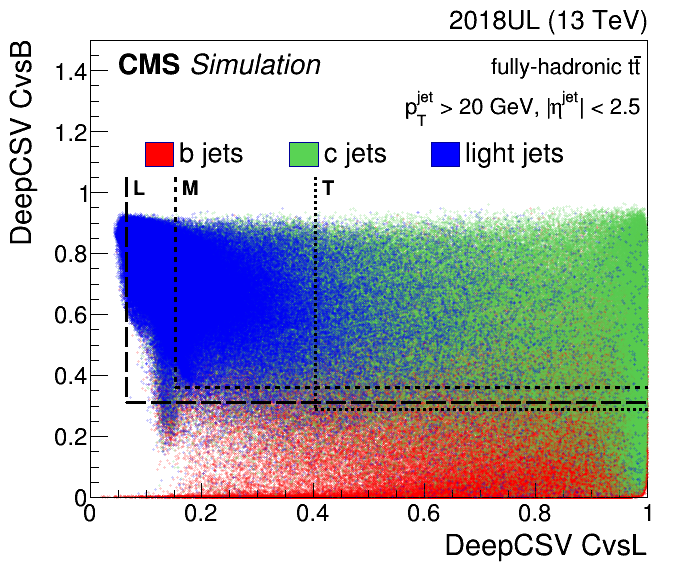

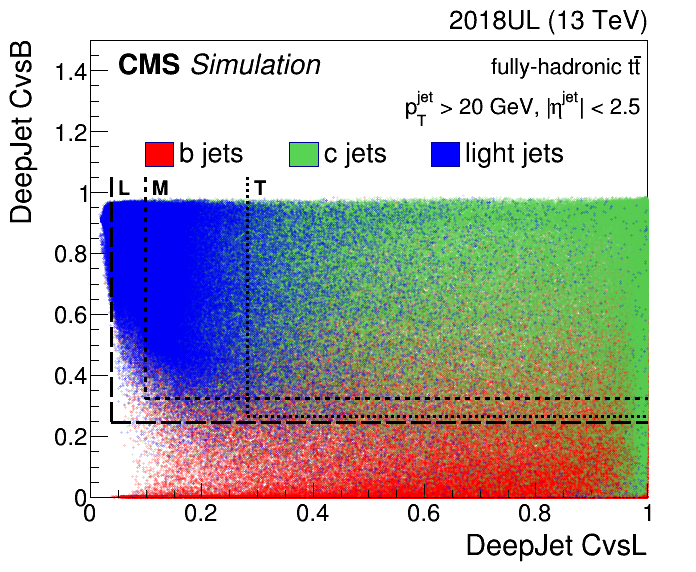

In [8]:
ROOT.gStyle.SetOptStat(0)

canvas_dict = {}
plot_dict = {}
legend_dict = {}
lines_dict = {}


latex_year = ROOT.TLatex()
latex_year.SetTextFont(43)
latex_year.SetTextSize(28)
latex_year.SetTextAlign(32)

latex_cms = ROOT.TLatex()
latex_cms.SetTextFont(43)
latex_cms.SetTextSize(30)
latex_cms.SetTextAlign(11)

latex_topology = ROOT.TLatex()
latex_topology.SetTextFont(43)
latex_topology.SetTextSize(24)
latex_topology.SetTextAlign(31)




for tagger in ["DeepCSV","DeepFlavour"]:

    disc_min = 0
    disc_max = 1
    ncuts = 300
    
    plot_dict[tagger] = {}
    plot_dict[tagger]["Plot_2D_B"] = ROOT.TH2D("Plot_2D_B%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_C"] = ROOT.TH2D("Plot_2D_C%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_DUSG"] = ROOT.TH2D("Plot_2D_DUSG%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
    
    #     
#     Plot_2D_B = ROOT.TH2D("Plot_2D_B%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
#     Plot_2D_C = ROOT.TH2D("Plot_2D_C%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
#     Plot_2D_DUSG = ROOT.TH2D("Plot_2D_DUSG%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
    
    min_n_flav = min(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']),len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']),len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']))
    
    
    plot_dict[tagger]["Plot_2D_B"].FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['b'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'])))
    plot_dict[tagger]["Plot_2D_C"].FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['c'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'])))
    plot_dict[tagger]["Plot_2D_DUSG"].FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['l'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'])))

    
#     Plot_2D_B.FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['b'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'])))
#     Plot_2D_C.FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['c'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'])))
#     Plot_2D_DUSG.FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['l'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'])))

    
    #Plot_2D_B.FillN(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']),discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['b'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'])))
    #Plot_2D_C.FillN(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']),discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['c'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'])))
    #Plot_2D_DUSG.FillN(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']),discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['l'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'])))

    canvas_dict[tagger] = ROOT.TCanvas("c_%s"%tagger,"c_%s"%tagger,700,600)
    canvas_dict[tagger].cd()
    ROOT.gPad.SetMargin(0.13,0.07,0.13,0.07)
    legend_dict[tagger] = ROOT.TLegend(0.2,0.7,0.90,0.76)
    legend_dict[tagger].SetNColumns(3)
    legend_dict[tagger].SetFillColor(0)
    legend_dict[tagger].SetFillStyle(0)
    legend_dict[tagger].SetBorderSize(0)
    
    
    
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetTitleOffset(1.1)
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetLabelSize(0.045)
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetNdivisions(510)
    plot_dict[tagger]["Plot_2D_B"].GetXaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_B"].GetXaxis().SetLabelSize(0.045)
    plot_dict[tagger]["Plot_2D_B"].GetXaxis().SetNdivisions(505)
    plot_dict[tagger]["Plot_2D_B"].GetZaxis().SetLabelSize(0.055)
    plot_dict[tagger]["Plot_2D_C"].GetYaxis().SetTitleOffset(1.1)
    plot_dict[tagger]["Plot_2D_C"].GetYaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_C"].GetYaxis().SetLabelSize(0.045)
    plot_dict[tagger]["Plot_2D_C"].GetXaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_C"].GetXaxis().SetLabelSize(0.055)
    plot_dict[tagger]["Plot_2D_C"].GetZaxis().SetLabelSize(0.055)
    plot_dict[tagger]["Plot_2D_DUSG"].GetYaxis().SetTitleOffset(1.1)
    plot_dict[tagger]["Plot_2D_DUSG"].GetYaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_DUSG"].GetYaxis().SetLabelSize(0.045)
    plot_dict[tagger]["Plot_2D_DUSG"].GetXaxis().SetTitleSize(0.065)
    plot_dict[tagger]["Plot_2D_DUSG"].GetXaxis().SetLabelSize(0.055)
    plot_dict[tagger]["Plot_2D_DUSG"].GetZaxis().SetLabelSize(0.055)

    plot_dict[tagger]["Plot_2D_B"].SetMarkerColorAlpha(ROOT.kRed,0.2)
    plot_dict[tagger]["Plot_2D_B"].SetFillColor(ROOT.kRed)
    plot_dict[tagger]["Plot_2D_B"].SetMarkerStyle(6)
    legend_dict[tagger].AddEntry(plot_dict[tagger]["Plot_2D_B"],"b jets","f")
    #ROOT.gPad.SetTickx(1)
    #ROOT.gPad.SetTicky(1)
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetRangeUser(disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_B"].Draw()


    plot_dict[tagger]["Plot_2D_C"].SetMarkerColorAlpha(8,0.2)
    plot_dict[tagger]["Plot_2D_C"].SetFillColor(8)
    plot_dict[tagger]["Plot_2D_C"].SetMarkerStyle(6)
    legend_dict[tagger].AddEntry(plot_dict[tagger]["Plot_2D_C"],"c jets","f")
    plot_dict[tagger]["Plot_2D_C"].GetYaxis().SetRangeUser(disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_C"].Draw("same")


    plot_dict[tagger]["Plot_2D_DUSG"].SetMarkerColorAlpha(ROOT.kBlue,0.2)
    plot_dict[tagger]["Plot_2D_DUSG"].SetFillColor(ROOT.kBlue)
    plot_dict[tagger]["Plot_2D_DUSG"].SetMarkerStyle(6)
    legend_dict[tagger].AddEntry(plot_dict[tagger]["Plot_2D_DUSG"],"light jets","f")
    plot_dict[tagger]["Plot_2D_DUSG"].GetYaxis().SetRangeUser(disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_DUSG"].Draw("same")

    legend_dict[tagger].Draw("same")\
    
    wp_dict = {"L":[out_dict[tagger]["loose"]["cut CvsL"],out_dict[tagger]["loose"]["cut CvsB"],9,0.18],"M":[out_dict[tagger]["medium"]["cut CvsL"],out_dict[tagger]["medium"]["cut CvsB"],7,0.26],"T":[out_dict[tagger]["tight"]["cut CvsL"],out_dict[tagger]["tight"]["cut CvsB"],2,0.79]} 
    lines_dict[tagger] = {}
    for wp,borders in wp_dict.iteritems():
        lines_dict[tagger][wp+"_h"] = ROOT.TLine()
        lines_dict[tagger][wp+"_h"].SetLineStyle(borders[2])
        lines_dict[tagger][wp+"_h"].SetLineColor(1)
        lines_dict[tagger][wp+"_h"].SetLineWidth(3)
        lines_dict[tagger][wp+"_h"].DrawLine(borders[0],borders[1],1,borders[1])
        lines_dict[tagger][wp+"_v"] = ROOT.TLine()
        lines_dict[tagger][wp+"_v"].SetLineStyle(borders[2])
        lines_dict[tagger][wp+"_v"].SetLineColor(1)
        lines_dict[tagger][wp+"_v"].SetLineWidth(3)
        lines_dict[tagger][wp+"_v"].DrawLine(borders[0],borders[1],borders[0],1.05)
        lines_dict[tagger][wp+"_txt"] = ROOT.TPaveText(borders[0]+0.01,1-0.05,borders[0]+0.05,1.03,"NB")
        lines_dict[tagger][wp+"_txt"].SetTextAlign(11)
        lines_dict[tagger][wp+"_txt"].AddText("#bf{"+wp+"}")
        lines_dict[tagger][wp+"_txt"].SetTextFont(43)
        lines_dict[tagger][wp+"_txt"].SetTextSize(22)
        lines_dict[tagger][wp+"_txt"].SetFillColor(0)
        lines_dict[tagger][wp+"_txt"].SetFillStyle(0)
        lines_dict[tagger][wp+"_txt"].SetBorderSize(0)
        lines_dict[tagger][wp+"_txt"].Draw("same")
    
    latex_year.DrawLatexNDC(0.93,0.96,year_label+" (13 TeV)")
    latex_cms.DrawLatexNDC(0.17,0.87,"#bf{CMS} #it{Simulation}")
    latex_topology.DrawLatexNDC(0.92,0.87,sample)
    latex_topology.DrawLatexNDC(0.92,0.80,"p_{T}^{jet} > %i GeV, |#eta^{jet}| < %.1f"%(min_pt,max_abs_eta))
    
    
    canvas_dict[tagger].Draw()
    canvas_dict[tagger].SaveAs("./plots/2D_CvsL_CvsB_Scatter_%s.pdf"%tagger)
    canvas_dict[tagger].SaveAs("./plots/2D_CvsL_CvsB_Scatter_%s.png"%tagger)
    canvas_dict[tagger].SaveAs("./plots/2D_CvsL_CvsB_Scatter_%s.C"%tagger)

In [9]:
from copy import deepcopy
ncuts=20
binning_dict = {} 
sorted_discriminator_dict = deepcopy(discriminator_dict)
for tagger, flav_dicts in sorted_discriminator_dict.iteritems():
    binning_dict[tagger]={}
    for flav, values in flav_dicts.iteritems():
        sorted_discriminator_dict[tagger][flav]=sorted(discriminator_dict[tagger][flav])
        #binning_dict[tagger][flav] = []
        indices = np.arange(0,len(sorted_discriminator_dict[tagger][flav]),len(sorted_discriminator_dict[tagger][flav])/ncuts)
        binning_dict[tagger][flav] = [i for i in map(sorted_discriminator_dict[tagger][flav].__getitem__, indices) if i > 0]

cuts = sorted(np.concatenate((binning_dict[tagger]["b"],binning_dict[tagger]["l"])))

cuts2d = list(permutations(cuts,2))

100%|██████████| 1406/1406 [00:19<00:00, 73.86it/s] 
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_DeepCSV
Info in <TCanvas::Print>: pdf file ./plots/EfficiencyMap_ctagger_DeepCSV.pdf has been created
Info in <TCanvas::Print>: png file ./plots/EfficiencyMap_ctagger_DeepCSV.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ./plots/EfficiencyMap_ctagger_DeepCSV.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_DeepFlavour
Info in <TCanvas::Print>: pdf file ./plots/EfficiencyMap_ctagger_DeepFlavour.pdf has been created
Info in <TCanvas::Print>: png file ./plots/EfficiencyMap_ctagger_DeepFlavour.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ./plots/EfficiencyMap_ctagger_DeepFlavour.C has been generated


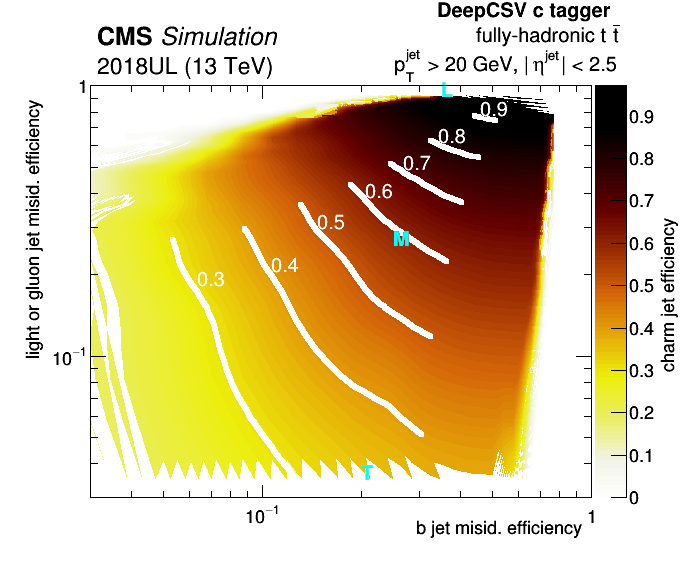

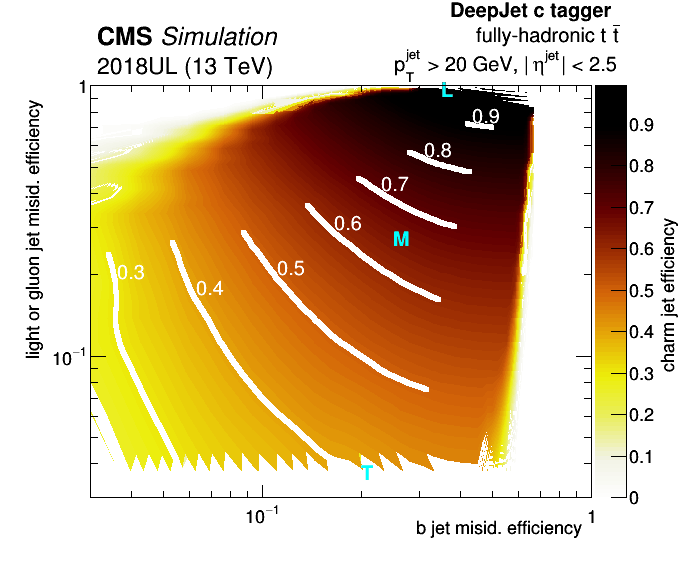

In [10]:
NRGBs = 11
NCont = 255
stops = np.arange(0,1.1,0.09)
red = np.asarray( [255./255., 242./255., 234./255., 237./255., 230./255., 212./255., 156./255., 99./255., 45./255., 0./255.])
green = np.asarray( [255./255., 243./255., 238./255., 238./255., 168./255., 101./255.,  45./255.,  0./255.,  0./255., 0./255.])
blue = np.asarray( [255./255., 230./255.,  95./255.,  11./255.,   8./255.,   9./255.,   3./255.,  1./255.,  1./255., 0./255.])
#Idx = TColor::CreateGradientColorTable(9, stops, red, green, blue, 255, alpha);
ROOT.TColor.CreateGradientColorTable(NRGBs, stops, red, green, blue, NCont)
ROOT.gStyle.SetNumberContours(99)

latex_year = ROOT.TLatex()
latex_year.SetTextFont(43)
latex_year.SetTextSize(25)
latex_year.SetTextAlign(11)

latex_cms = ROOT.TLatex()
latex_cms.SetTextFont(43)
latex_cms.SetTextSize(27)
latex_cms.SetTextAlign(11)

latex_topology = ROOT.TLatex()
latex_topology.SetTextFont(43)
latex_topology.SetTextSize(22)
latex_topology.SetTextAlign(31)

latex_tagger = ROOT.TLatex()
latex_tagger.SetTextFont(43)
latex_tagger.SetTextSize(22)
latex_tagger.SetTextAlign(31)

nbins=100
hist_dict = {}
graph_dict = {}
cont_dict = {}
conttext_dict = {}
wp_graph_dict = {}
wp_text_dict = {}

for tagger in ["DeepCSV","DeepFlavour"]:
    hist_dict[tagger] = ROOT.TH2D("efficiency_hist_%s"%tagger," ;b jet misid. efficiency; light or gluon jet misid. efficiency",nbins,0,1,nbins,0,1)
    graph_dict[tagger] = ROOT.TGraph2D()#len(cuts2d))
    
    canvas_dict[tagger] = ROOT.TCanvas("c_%s"%tagger,"c_%s"%tagger,700,600)
    canvas_dict[tagger].cd()
    ROOT.gPad.SetMargin(0.13,0.15,0.13,0.15)
    
    #
    # DEFINE BOUNDARIES
    #
    left_point1 = (0,0.2)
    left_point2 = (0.6,1.)
    left_rico = float(left_point2[1]-left_point1[1])/(left_point2[0]-left_point1[0])
    left_boundry = ROOT.TF1("left_boundry","%.2f*(x-%.2f) + %.2f"%(left_rico,left_point1[0],left_point1[1]),0,1)
    left_boundry.SetLineWidth(10)
    left_boundry.SetLineColor(1)
    
    
    right_point1 = (0.3,0.)
    right_point2 = (0.6,1.)
    right_rico = float(right_point2[1]-right_point1[1])/(right_point2[0]-right_point1[0])
    right_boundry = ROOT.TF1("right_boundry","%.2f*(x-%.2f) + %.2f"%(right_rico,right_point1[0],right_point1[1]),0,1)
    right_boundry.SetLineWidth(10)
    right_boundry.SetLineColor(1)

    
    counter = 0
    for c in tqdm(cuts2d, position=0, leave=True):
        tag_mask_light = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']>c[0])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['l']>c[1])
        all_light = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'])
        tagged_light = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'][tag_mask_light])
        eff_light = float(tagged_light) / float(all_light)

        tag_mask_b = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']>c[0])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['b']>c[1])
        all_b = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'])
        tagged_b = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'][tag_mask_b])
        eff_b = float(tagged_b) / float(all_b)

        tag_mask_c = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']>c[0])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['c']>c[1])
        all_c = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'])
        tagged_c = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'][tag_mask_c])
        eff_c = float(tagged_c) / float(all_c)
        
        #hist_dict[tagger].SetBinContent(hist_dict[tagger].FindBin(eff_b,eff_light),eff_c)
        #if eff_light < left_boundry.Eval(eff_b) and eff_light > right_boundry.Eval(eff_b):
        graph_dict[tagger].SetPoint(counter,eff_b,eff_light,eff_c)
        counter+=1
    
    
    
   
    
    hist_dict[tagger].Draw("")
    #left_boundry.Draw("same l")
    #right_boundry.Draw("same l")
    hist_dict[tagger].GetXaxis().SetRangeUser(0.03,1)
    hist_dict[tagger].GetYaxis().SetRangeUser(0.03,1)
    
    hist_dict[tagger+"_bis"] = graph_dict[tagger].GetHistogram()
    hist_dict[tagger+"_bis"].GetZaxis().SetTitle("charm jet efficiency")
    hist_dict[tagger+"_bis"].GetZaxis().CenterTitle()
    hist_dict[tagger+"_bis"].GetZaxis().SetTitleOffset(1.1)
    hist_dict[tagger+"_bis"].Smooth()
    
    hist_dict[tagger+"_bis_discrete"] = hist_dict[tagger+"_bis"].Clone()
    contours = array("d",[0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    hist_dict[tagger+"_bis_discrete"].SetContour(len(contours),array("d",contours))
    hist_dict[tagger+"_bis_discrete"].Draw("CONT same LIST")
    canvas_dict[tagger].Update()
    
    hist_dict[tagger+"_bis"].Draw("CONTZ same")
    
    

    conts = ROOT.gROOT.GetListOfSpecials().FindObject("contours")
    
    for idx,cont in enumerate(conts):
        gr=(cont.First()).Clone()
#         cont_dict[tagger+"_cont_"+str(idx)].SetLineWidth(5)
#         cont_dict[tagger+"_cont_"+str(idx)].SetLineColor(0)
#         cont_dict[tagger+"_cont_"+str(idx)].Draw("C")
        x_values = array("d",np.asarray(gr.GetX()))
        y_values = array("d",np.asarray(gr.GetY()))
        cont_dict[tagger+"_cont_"+str(idx)] = ROOT.TGraph()
        
        
        ii=0
        for x,y in zip(x_values,y_values):
            if y < left_boundry.Eval(x) and y > right_boundry.Eval(x): 
                cont_dict[tagger+"_cont_"+str(idx)].SetPoint(ii,x,y)
                ii+=1
        cont_dict[tagger+"_cont_"+str(idx)].SetLineWidth(5)
        cont_dict[tagger+"_cont_"+str(idx)].SetLineColor(0)
        cont_dict[tagger+"_cont_"+str(idx)].Draw("C")
        
        index_text = int(len(array("d",np.asarray(cont_dict[tagger+"_cont_"+str(idx)].GetX())))/1.3)
        x_text = array("d",np.asarray(cont_dict[tagger+"_cont_"+str(idx)].GetX()))[index_text]
        y_text = array("d",np.asarray(cont_dict[tagger+"_cont_"+str(idx)].GetY()))[index_text]
        conttext_dict[tagger+"_cont_text_"+str(idx)] = ROOT.TPaveText(x_text,y_text,x_text+0.01,y_text+0.01,"NB")
        conttext_dict[tagger+"_cont_text_"+str(idx)].SetTextAlign(11)
        conttext_dict[tagger+"_cont_text_"+str(idx)].AddText("%.1f"%contours[idx])
        conttext_dict[tagger+"_cont_text_"+str(idx)].SetTextFont(43)
        conttext_dict[tagger+"_cont_text_"+str(idx)].SetTextAlign(11)
        conttext_dict[tagger+"_cont_text_"+str(idx)].SetTextSize(22)
        conttext_dict[tagger+"_cont_text_"+str(idx)].SetTextColor(0)
        conttext_dict[tagger+"_cont_text_"+str(idx)].SetFillColor(0)
        conttext_dict[tagger+"_cont_text_"+str(idx)].SetFillStyle(0)
        conttext_dict[tagger+"_cont_text_"+str(idx)].SetBorderSize(0)
        conttext_dict[tagger+"_cont_text_"+str(idx)].Draw("same")
    
    wp_graph_dict[tagger] = {}
    for wp_ in ["loose","medium","tight"]:
        wp_graph_dict[tagger][wp_]=ROOT.TGraph()
        wp_graph_dict[tagger][wp_].SetPoint(0,out_dict[tagger][wp_]["Eff bottom"],out_dict[tagger][wp_]["Eff light"])
        wp_graph_dict[tagger][wp_].SetMarkerColor(ROOT.kCyan+1)
        wp_graph_dict[tagger][wp_].SetMarkerStyle(34)
        wp_graph_dict[tagger][wp_].SetMarkerSize(2)
        #wp_graph_dict[tagger][wp_].Draw("p")
        wp_text_dict[tagger+"_cont_text_"+wp_] = ROOT.TPaveText(out_dict[tagger][wp_]["Eff bottom"],out_dict[tagger][wp_]["Eff light"],out_dict[tagger][wp_]["Eff bottom"]+0.01,out_dict[tagger][wp_]["Eff light"]+0.01,"NB")
        wp_text_dict[tagger+"_cont_text_"+wp_].SetTextAlign(22)
        if wp_ == "loose": wp_text_dict[tagger+"_cont_text_"+wp_].AddText("#bf{L}")
        if wp_ == "medium": wp_text_dict[tagger+"_cont_text_"+wp_].AddText("#bf{M}")
        if wp_ == "tight": wp_text_dict[tagger+"_cont_text_"+wp_].AddText("#bf{T}")
        wp_text_dict[tagger+"_cont_text_"+wp_].SetTextFont(43)
        wp_text_dict[tagger+"_cont_text_"+wp_].SetTextAlign(11)
        wp_text_dict[tagger+"_cont_text_"+wp_].SetTextSize(22)
        wp_text_dict[tagger+"_cont_text_"+wp_].SetTextColor(ROOT.kCyan)
        wp_text_dict[tagger+"_cont_text_"+wp_].SetFillColor(0)
        wp_text_dict[tagger+"_cont_text_"+wp_].SetFillStyle(0)
        wp_text_dict[tagger+"_cont_text_"+wp_].SetBorderSize(0)
        wp_text_dict[tagger+"_cont_text_"+wp_].Draw("same")
    
    
    ROOT.gPad.SetLogy(1)
    ROOT.gPad.SetLogx(1)
    ROOT.gPad.SetTickx(1)
    ROOT.gPad.SetTicky(1)
    ROOT.gPad.RedrawAxis()
    
    latex_year.DrawLatexNDC(0.14,0.87,year_label+" (13 TeV)")
    latex_cms.DrawLatexNDC(0.14,0.92,"#bf{CMS} #it{Simulation}")
    latex_tagger.DrawLatexNDC(0.89,0.97,"#bf{%s c tagger}"%tagger.replace("Flavour","Jet"))
    latex_topology.DrawLatexNDC(0.89,0.925,sample)
    latex_topology.DrawLatexNDC(0.89,0.875,"p_{T}^{jet} > %i GeV, |#eta^{jet}| < %.1f"%(min_pt,max_abs_eta))
    
    
    canvas_dict[tagger].Draw()
    canvas_dict[tagger].SaveAs("./plots/EfficiencyMap_ctagger_%s.pdf"%tagger)
    canvas_dict[tagger].SaveAs("./plots/EfficiencyMap_ctagger_%s.png"%tagger)
    canvas_dict[tagger].SaveAs("./plots/EfficiencyMap_ctagger_%s.C"%tagger)
        

### Efficiency vs pT/eta/nPV

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_DeepCSV
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_pt_c (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_pt_c (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_pt_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_pt_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_pt_l (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_pt_l (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_eta_c (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_eta_c (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_eta_b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DeepCSV_eta_b (Potential memory leak).
Warning in <TROOT::

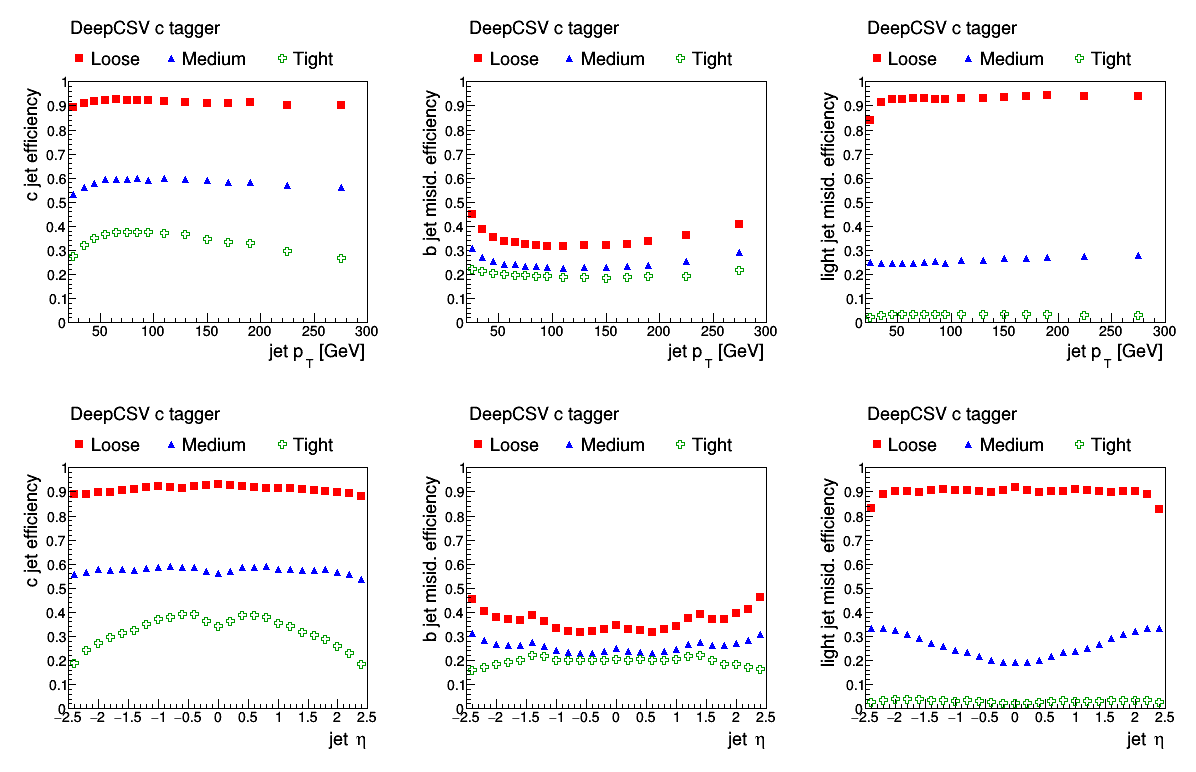

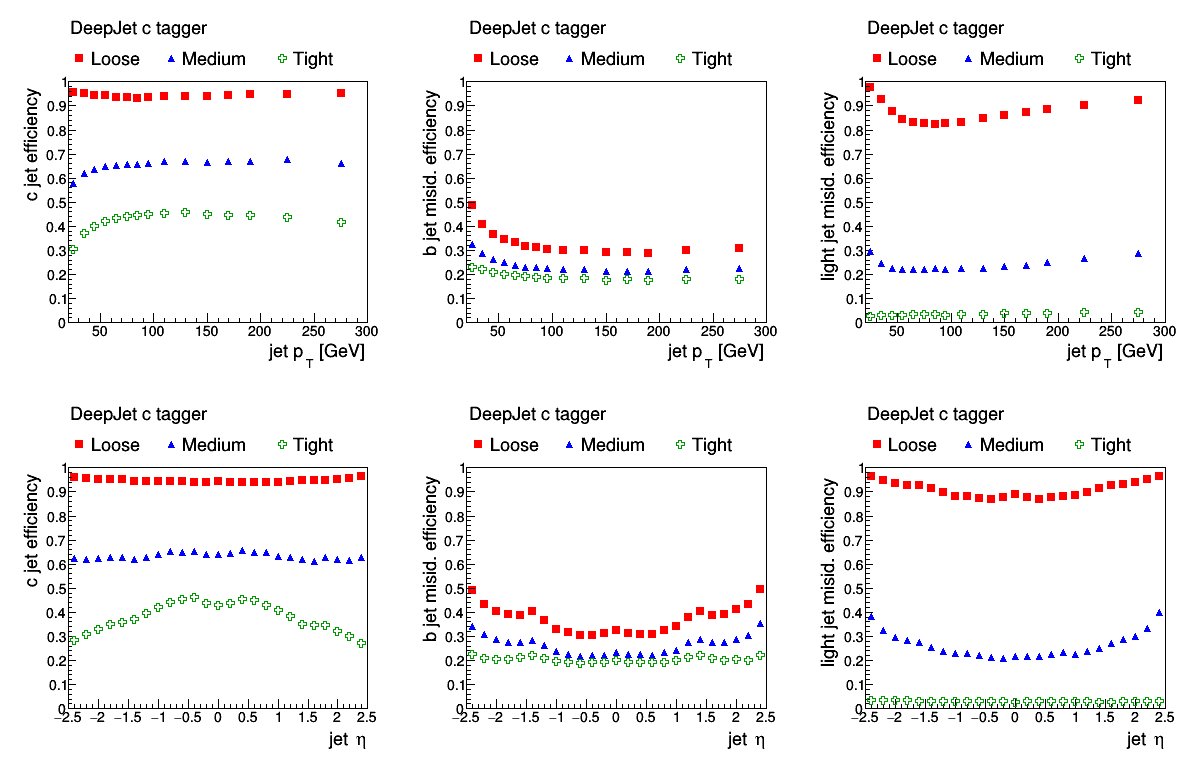

In [11]:
canvas_dict = {}
hist_dict = {}
legend_dict = {}

pt_bins = [20,30,40,50,60,70,80,90,100,120,140,160,180,200,250,300]
eta_bins = np.arange(-2.5,2.6,0.2)


for tagger in ["DeepCSV","DeepFlavour"]:
    hist_dict[tagger]={}
    legend_dict[tagger] = {}
    canvas_dict[tagger] = ROOT.TCanvas("c_"+tagger,"c_"+tagger,1200,800)
    canvas_dict[tagger].Divide(3,2)
    
    # pt, c jets
    canvas_dict[tagger].cd(1)
    ROOT.gPad.SetMargin(0.15,0.05,0.15,0.2)
    hist_dict[tagger]["pt_c"] = ROOT.TH1D(tagger+"_pt_c","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_c"].FillN(len(discriminator_dict['Jet_pt']['c']),discriminator_dict['Jet_pt']['c'],np.ones(len(discriminator_dict['Jet_pt']['c'])))
    tag_mask_c_loose = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']>out_dict[tagger]["loose"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['c']>out_dict[tagger]["loose"]["cut CvsB"])  
    hist_dict[tagger]["pt_loose_c"] = ROOT.TH1D(tagger+"_pt_loose_c","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_loose_c"].FillN(len(discriminator_dict['Jet_pt']['c'][tag_mask_c_loose]),discriminator_dict['Jet_pt']['c'][tag_mask_c_loose],np.ones(len(discriminator_dict['Jet_pt']['c'][tag_mask_c_loose])))   
    hist_dict[tagger]["pt_loose_c_eff"] = hist_dict[tagger]["pt_loose_c"].Clone()
    hist_dict[tagger]["pt_loose_c_eff"].Divide(hist_dict[tagger]["pt_c"])
    hist_dict[tagger]["pt_loose_c_eff"].SetMarkerStyle(21)
    hist_dict[tagger]["pt_loose_c_eff"].SetMarkerColor(ROOT.kRed)
    hist_dict[tagger]["pt_loose_c_eff"].GetYaxis().SetRangeUser(0,1)
    hist_dict[tagger]["pt_loose_c_eff"].GetYaxis().SetTitle("c jet efficiency")
    hist_dict[tagger]["pt_loose_c_eff"].GetYaxis().SetTitleFont(43)
    hist_dict[tagger]["pt_loose_c_eff"].GetYaxis().SetTitleSize(20)
    hist_dict[tagger]["pt_loose_c_eff"].GetYaxis().SetTitleOffset(2.3)
    hist_dict[tagger]["pt_loose_c_eff"].GetYaxis().SetLabelFont(43)
    hist_dict[tagger]["pt_loose_c_eff"].GetYaxis().SetLabelSize(15)
    hist_dict[tagger]["pt_loose_c_eff"].GetXaxis().SetTitle("jet p_{T} [GeV]")
    hist_dict[tagger]["pt_loose_c_eff"].GetXaxis().SetTitleFont(43)
    hist_dict[tagger]["pt_loose_c_eff"].GetXaxis().SetTitleSize(20)
    hist_dict[tagger]["pt_loose_c_eff"].GetXaxis().SetTitleOffset(2.1)
    hist_dict[tagger]["pt_loose_c_eff"].GetXaxis().SetLabelFont(43)
    hist_dict[tagger]["pt_loose_c_eff"].GetXaxis().SetLabelSize(15)
    hist_dict[tagger]["pt_loose_c_eff"].Draw("p")

    hist_dict[tagger]["pt_c"] = ROOT.TH1D(tagger+"_pt_c","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_c"].FillN(len(discriminator_dict['Jet_pt']['c']),discriminator_dict['Jet_pt']['c'],np.ones(len(discriminator_dict['Jet_pt']['c'])))
    tag_mask_c_medium = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']>out_dict[tagger]["medium"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['c']>out_dict[tagger]["medium"]["cut CvsB"])  
    hist_dict[tagger]["pt_medium_c"] = ROOT.TH1D(tagger+"_pt_medium_c","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_medium_c"].FillN(len(discriminator_dict['Jet_pt']['c'][tag_mask_c_medium]),discriminator_dict['Jet_pt']['c'][tag_mask_c_medium],np.ones(len(discriminator_dict['Jet_pt']['c'][tag_mask_c_medium])))   
    hist_dict[tagger]["pt_medium_c_eff"] = hist_dict[tagger]["pt_medium_c"].Clone()
    hist_dict[tagger]["pt_medium_c_eff"].Divide(hist_dict[tagger]["pt_c"])
    hist_dict[tagger]["pt_medium_c_eff"].SetMarkerStyle(22)
    hist_dict[tagger]["pt_medium_c_eff"].SetMarkerColor(ROOT.kBlue)
    hist_dict[tagger]["pt_medium_c_eff"].Draw("p same")

    hist_dict[tagger]["pt_c"] = ROOT.TH1D(tagger+"_pt_c","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_c"].FillN(len(discriminator_dict['Jet_pt']['c']),discriminator_dict['Jet_pt']['c'],np.ones(len(discriminator_dict['Jet_pt']['c'])))
    tag_mask_c_tight = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']>out_dict[tagger]["tight"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['c']>out_dict[tagger]["tight"]["cut CvsB"])  
    hist_dict[tagger]["pt_tight_c"] = ROOT.TH1D(tagger+"_pt_tight_c","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_tight_c"].FillN(len(discriminator_dict['Jet_pt']['c'][tag_mask_c_tight]),discriminator_dict['Jet_pt']['c'][tag_mask_c_tight],np.ones(len(discriminator_dict['Jet_pt']['c'][tag_mask_c_tight])))   
    hist_dict[tagger]["pt_tight_c_eff"] = hist_dict[tagger]["pt_tight_c"].Clone()
    hist_dict[tagger]["pt_tight_c_eff"].Divide(hist_dict[tagger]["pt_c"])
    hist_dict[tagger]["pt_tight_c_eff"].SetMarkerStyle(28)
    hist_dict[tagger]["pt_tight_c_eff"].SetMarkerColor(ROOT.kGreen+2)
    hist_dict[tagger]["pt_tight_c_eff"].Draw("p same")

    legend_dict[tagger]['pt_c'] = ROOT.TLegend(0.15,0.82,0.9,0.99)
    legend_dict[tagger]['pt_c'].SetNColumns(3)
    legend_dict[tagger]['pt_c'].SetTextFont(43)
    legend_dict[tagger]['pt_c'].SetTextSize(20)
    legend_dict[tagger]['pt_c'].SetBorderSize(0)
    legend_dict[tagger]['pt_c'].SetFillStyle(0)
    legend_dict[tagger]['pt_c'].SetHeader(tagger.replace("Flavour","Jet") + " c tagger")
    legend_dict[tagger]['pt_c'].AddEntry(hist_dict[tagger]["pt_loose_c_eff"],"Loose","p")
    legend_dict[tagger]['pt_c'].AddEntry(hist_dict[tagger]["pt_medium_c_eff"],"Medium","p")
    legend_dict[tagger]['pt_c'].AddEntry(hist_dict[tagger]["pt_tight_c_eff"],"Tight","p")
    legend_dict[tagger]['pt_c'].Draw('same')
    
    # pt, b jets
    canvas_dict[tagger].cd(2)
    ROOT.gPad.SetMargin(0.15,0.05,0.15,0.2)
    hist_dict[tagger]["pt_b"] = ROOT.TH1D(tagger+"_pt_b","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_b"].FillN(len(discriminator_dict['Jet_pt']['b']),discriminator_dict['Jet_pt']['b'],np.ones(len(discriminator_dict['Jet_pt']['b'])))
    tag_mask_b_loose = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']>out_dict[tagger]["loose"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['b']>out_dict[tagger]["loose"]["cut CvsB"])  
    hist_dict[tagger]["pt_loose_b"] = ROOT.TH1D(tagger+"_pt_loose_b","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_loose_b"].FillN(len(discriminator_dict['Jet_pt']['b'][tag_mask_b_loose]),discriminator_dict['Jet_pt']['b'][tag_mask_b_loose],np.ones(len(discriminator_dict['Jet_pt']['b'][tag_mask_b_loose])))   
    hist_dict[tagger]["pt_loose_b_eff"] = hist_dict[tagger]["pt_loose_b"].Clone()
    hist_dict[tagger]["pt_loose_b_eff"].Divide(hist_dict[tagger]["pt_b"])
    hist_dict[tagger]["pt_loose_b_eff"].SetMarkerStyle(21)
    hist_dict[tagger]["pt_loose_b_eff"].SetMarkerColor(ROOT.kRed)
    hist_dict[tagger]["pt_loose_b_eff"].GetYaxis().SetRangeUser(0,1)
    hist_dict[tagger]["pt_loose_b_eff"].GetYaxis().SetTitle("b jet misid. efficiency")
    hist_dict[tagger]["pt_loose_b_eff"].GetYaxis().SetTitleFont(43)
    hist_dict[tagger]["pt_loose_b_eff"].GetYaxis().SetTitleSize(20)
    hist_dict[tagger]["pt_loose_b_eff"].GetYaxis().SetTitleOffset(2.3)
    hist_dict[tagger]["pt_loose_b_eff"].GetYaxis().SetLabelFont(43)
    hist_dict[tagger]["pt_loose_b_eff"].GetYaxis().SetLabelSize(15)
    hist_dict[tagger]["pt_loose_b_eff"].GetXaxis().SetTitle("jet p_{T} [GeV]")
    hist_dict[tagger]["pt_loose_b_eff"].GetXaxis().SetTitleFont(43)
    hist_dict[tagger]["pt_loose_b_eff"].GetXaxis().SetTitleSize(20)
    hist_dict[tagger]["pt_loose_b_eff"].GetXaxis().SetTitleOffset(2.1)
    hist_dict[tagger]["pt_loose_b_eff"].GetXaxis().SetLabelFont(43)
    hist_dict[tagger]["pt_loose_b_eff"].GetXaxis().SetLabelSize(15)
    hist_dict[tagger]["pt_loose_b_eff"].Draw("p")
    
    hist_dict[tagger]["pt_b"] = ROOT.TH1D(tagger+"_pt_b","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_b"].FillN(len(discriminator_dict['Jet_pt']['b']),discriminator_dict['Jet_pt']['b'],np.ones(len(discriminator_dict['Jet_pt']['b'])))
    tag_mask_b_medium = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']>out_dict[tagger]["medium"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['b']>out_dict[tagger]["medium"]["cut CvsB"])  
    hist_dict[tagger]["pt_medium_b"] = ROOT.TH1D(tagger+"_pt_medium_b","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_medium_b"].FillN(len(discriminator_dict['Jet_pt']['b'][tag_mask_b_medium]),discriminator_dict['Jet_pt']['b'][tag_mask_b_medium],np.ones(len(discriminator_dict['Jet_pt']['b'][tag_mask_b_medium])))   
    hist_dict[tagger]["pt_medium_b_eff"] = hist_dict[tagger]["pt_medium_b"].Clone()
    hist_dict[tagger]["pt_medium_b_eff"].Divide(hist_dict[tagger]["pt_b"])
    hist_dict[tagger]["pt_medium_b_eff"].SetMarkerStyle(22)
    hist_dict[tagger]["pt_medium_b_eff"].SetMarkerColor(ROOT.kBlue)
    hist_dict[tagger]["pt_medium_b_eff"].Draw("p same")
    
    hist_dict[tagger]["pt_b"] = ROOT.TH1D(tagger+"_pt_b","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_b"].FillN(len(discriminator_dict['Jet_pt']['b']),discriminator_dict['Jet_pt']['b'],np.ones(len(discriminator_dict['Jet_pt']['b'])))
    tag_mask_b_tight = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']>out_dict[tagger]["tight"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['b']>out_dict[tagger]["tight"]["cut CvsB"])  
    hist_dict[tagger]["pt_tight_b"] = ROOT.TH1D(tagger+"_pt_tight_b","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_tight_b"].FillN(len(discriminator_dict['Jet_pt']['b'][tag_mask_b_tight]),discriminator_dict['Jet_pt']['b'][tag_mask_b_tight],np.ones(len(discriminator_dict['Jet_pt']['b'][tag_mask_b_tight])))   
    hist_dict[tagger]["pt_tight_b_eff"] = hist_dict[tagger]["pt_tight_b"].Clone()
    hist_dict[tagger]["pt_tight_b_eff"].Divide(hist_dict[tagger]["pt_b"])
    hist_dict[tagger]["pt_tight_b_eff"].SetMarkerStyle(28)
    hist_dict[tagger]["pt_tight_b_eff"].SetMarkerColor(ROOT.kGreen+2)
    hist_dict[tagger]["pt_tight_b_eff"].Draw("p same")
    
    legend_dict[tagger]['pt_b'] = ROOT.TLegend(0.15,0.82,0.9,0.99)
    legend_dict[tagger]['pt_b'].SetNColumns(3)
    legend_dict[tagger]['pt_b'].SetTextFont(43)
    legend_dict[tagger]['pt_b'].SetTextSize(20)
    legend_dict[tagger]['pt_b'].SetBorderSize(0)
    legend_dict[tagger]['pt_b'].SetFillStyle(0)
    legend_dict[tagger]['pt_b'].SetHeader(tagger.replace("Flavour","Jet") + " c tagger")
    legend_dict[tagger]['pt_b'].AddEntry(hist_dict[tagger]["pt_loose_b_eff"],"Loose","p")
    legend_dict[tagger]['pt_b'].AddEntry(hist_dict[tagger]["pt_medium_b_eff"],"Medium","p")
    legend_dict[tagger]['pt_b'].AddEntry(hist_dict[tagger]["pt_tight_b_eff"],"Tight","p")
    legend_dict[tagger]['pt_b'].Draw('same')
    
    # light pt
    canvas_dict[tagger].cd(3)
    ROOT.gPad.SetMargin(0.15,0.05,0.15,0.2)
    hist_dict[tagger]["pt_l"] = ROOT.TH1D(tagger+"_pt_l","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_l"].FillN(len(discriminator_dict['Jet_pt']['l']),discriminator_dict['Jet_pt']['l'],np.ones(len(discriminator_dict['Jet_pt']['l'])))
    tag_mask_l_loose = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']>out_dict[tagger]["loose"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['l']>out_dict[tagger]["loose"]["cut CvsB"])  
    hist_dict[tagger]["pt_loose_l"] = ROOT.TH1D(tagger+"_pt_loose_l","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_loose_l"].FillN(len(discriminator_dict['Jet_pt']['l'][tag_mask_l_loose]),discriminator_dict['Jet_pt']['l'][tag_mask_l_loose],np.ones(len(discriminator_dict['Jet_pt']['l'][tag_mask_l_loose])))   
    hist_dict[tagger]["pt_loose_l_eff"] = hist_dict[tagger]["pt_loose_l"].Clone()
    hist_dict[tagger]["pt_loose_l_eff"].Divide(hist_dict[tagger]["pt_l"])
    hist_dict[tagger]["pt_loose_l_eff"].SetMarkerStyle(21)
    hist_dict[tagger]["pt_loose_l_eff"].SetMarkerColor(ROOT.kRed)
    hist_dict[tagger]["pt_loose_l_eff"].GetYaxis().SetRangeUser(0,1)
    hist_dict[tagger]["pt_loose_l_eff"].GetYaxis().SetTitle("light jet misid. efficiency")
    hist_dict[tagger]["pt_loose_l_eff"].GetYaxis().SetTitleFont(43)
    hist_dict[tagger]["pt_loose_l_eff"].GetYaxis().SetTitleSize(20)
    hist_dict[tagger]["pt_loose_l_eff"].GetYaxis().SetTitleOffset(2.3)
    hist_dict[tagger]["pt_loose_l_eff"].GetYaxis().SetLabelFont(43)
    hist_dict[tagger]["pt_loose_l_eff"].GetYaxis().SetLabelSize(15)
    hist_dict[tagger]["pt_loose_l_eff"].GetXaxis().SetTitle("jet p_{T} [GeV]")
    hist_dict[tagger]["pt_loose_l_eff"].GetXaxis().SetTitleFont(43)
    hist_dict[tagger]["pt_loose_l_eff"].GetXaxis().SetTitleSize(20)
    hist_dict[tagger]["pt_loose_l_eff"].GetXaxis().SetTitleOffset(2.1)
    hist_dict[tagger]["pt_loose_l_eff"].GetXaxis().SetLabelFont(43)
    hist_dict[tagger]["pt_loose_l_eff"].GetXaxis().SetLabelSize(15)
    hist_dict[tagger]["pt_loose_l_eff"].Draw("p")

    hist_dict[tagger]["pt_l"] = ROOT.TH1D(tagger+"_pt_l","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_l"].FillN(len(discriminator_dict['Jet_pt']['l']),discriminator_dict['Jet_pt']['l'],np.ones(len(discriminator_dict['Jet_pt']['l'])))
    tag_mask_l_medium = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']>out_dict[tagger]["medium"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['l']>out_dict[tagger]["medium"]["cut CvsB"])  
    hist_dict[tagger]["pt_medium_l"] = ROOT.TH1D(tagger+"_pt_medium_l","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_medium_l"].FillN(len(discriminator_dict['Jet_pt']['l'][tag_mask_l_medium]),discriminator_dict['Jet_pt']['l'][tag_mask_l_medium],np.ones(len(discriminator_dict['Jet_pt']['l'][tag_mask_l_medium])))   
    hist_dict[tagger]["pt_medium_l_eff"] = hist_dict[tagger]["pt_medium_l"].Clone()
    hist_dict[tagger]["pt_medium_l_eff"].Divide(hist_dict[tagger]["pt_l"])
    hist_dict[tagger]["pt_medium_l_eff"].SetMarkerStyle(22)
    hist_dict[tagger]["pt_medium_l_eff"].SetMarkerColor(ROOT.kBlue)
    hist_dict[tagger]["pt_medium_l_eff"].Draw("p same")

    hist_dict[tagger]["pt_l"] = ROOT.TH1D(tagger+"_pt_l","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_l"].FillN(len(discriminator_dict['Jet_pt']['l']),discriminator_dict['Jet_pt']['l'],np.ones(len(discriminator_dict['Jet_pt']['l'])))
    tag_mask_l_tight = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']>out_dict[tagger]["tight"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['l']>out_dict[tagger]["tight"]["cut CvsB"])  
    hist_dict[tagger]["pt_tight_l"] = ROOT.TH1D(tagger+"_pt_tight_l","",len(pt_bins)-1,array("d",pt_bins))
    hist_dict[tagger]["pt_tight_l"].FillN(len(discriminator_dict['Jet_pt']['l'][tag_mask_l_tight]),discriminator_dict['Jet_pt']['l'][tag_mask_l_tight],np.ones(len(discriminator_dict['Jet_pt']['l'][tag_mask_l_tight])))   
    hist_dict[tagger]["pt_tight_l_eff"] = hist_dict[tagger]["pt_tight_l"].Clone()
    hist_dict[tagger]["pt_tight_l_eff"].Divide(hist_dict[tagger]["pt_l"])
    hist_dict[tagger]["pt_tight_l_eff"].SetMarkerStyle(28)
    hist_dict[tagger]["pt_tight_l_eff"].SetMarkerColor(ROOT.kGreen+2)
    hist_dict[tagger]["pt_tight_l_eff"].Draw("p same")

    legend_dict[tagger]['pt_l'] = ROOT.TLegend(0.15,0.82,0.9,0.99)
    legend_dict[tagger]['pt_l'].SetNColumns(3)
    legend_dict[tagger]['pt_l'].SetTextFont(43)
    legend_dict[tagger]['pt_l'].SetTextSize(20)
    legend_dict[tagger]['pt_l'].SetBorderSize(0)
    legend_dict[tagger]['pt_l'].SetFillStyle(0)
    legend_dict[tagger]['pt_l'].SetHeader(tagger.replace("Flavour","Jet") + " c tagger")
    legend_dict[tagger]['pt_l'].AddEntry(hist_dict[tagger]["pt_loose_l_eff"],"Loose","p")
    legend_dict[tagger]['pt_l'].AddEntry(hist_dict[tagger]["pt_medium_l_eff"],"Medium","p")
    legend_dict[tagger]['pt_l'].AddEntry(hist_dict[tagger]["pt_tight_l_eff"],"Tight","p")
    legend_dict[tagger]['pt_l'].Draw('same')
    
    
    
    # eta, c jets
    canvas_dict[tagger].cd(4)
    ROOT.gPad.SetMargin(0.15,0.05,0.15,0.2)
    hist_dict[tagger]["eta_c"] = ROOT.TH1D(tagger+"_eta_c","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_c"].FillN(len(discriminator_dict['Jet_eta']['c']),discriminator_dict['Jet_eta']['c'],np.ones(len(discriminator_dict['Jet_eta']['c'])))
    tag_mask_c_loose = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']>out_dict[tagger]["loose"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['c']>out_dict[tagger]["loose"]["cut CvsB"])  
    hist_dict[tagger]["eta_loose_c"] = ROOT.TH1D(tagger+"_eta_loose_c","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_loose_c"].FillN(len(discriminator_dict['Jet_eta']['c'][tag_mask_c_loose]),discriminator_dict['Jet_eta']['c'][tag_mask_c_loose],np.ones(len(discriminator_dict['Jet_eta']['c'][tag_mask_c_loose])))   
    hist_dict[tagger]["eta_loose_c_eff"] = hist_dict[tagger]["eta_loose_c"].Clone()
    hist_dict[tagger]["eta_loose_c_eff"].Divide(hist_dict[tagger]["eta_c"])
    hist_dict[tagger]["eta_loose_c_eff"].SetMarkerStyle(21)
    hist_dict[tagger]["eta_loose_c_eff"].SetMarkerColor(ROOT.kRed)
    hist_dict[tagger]["eta_loose_c_eff"].GetYaxis().SetRangeUser(0,1)
    hist_dict[tagger]["eta_loose_c_eff"].GetYaxis().SetTitle("c jet efficiency")
    hist_dict[tagger]["eta_loose_c_eff"].GetYaxis().SetTitleFont(43)
    hist_dict[tagger]["eta_loose_c_eff"].GetYaxis().SetTitleSize(20)
    hist_dict[tagger]["eta_loose_c_eff"].GetYaxis().SetTitleOffset(2.3)
    hist_dict[tagger]["eta_loose_c_eff"].GetYaxis().SetLabelFont(43)
    hist_dict[tagger]["eta_loose_c_eff"].GetYaxis().SetLabelSize(15)
    hist_dict[tagger]["eta_loose_c_eff"].GetXaxis().SetTitle("jet #eta")
    hist_dict[tagger]["eta_loose_c_eff"].GetXaxis().SetTitleFont(43)
    hist_dict[tagger]["eta_loose_c_eff"].GetXaxis().SetTitleSize(20)
    hist_dict[tagger]["eta_loose_c_eff"].GetXaxis().SetTitleOffset(2.1)
    hist_dict[tagger]["eta_loose_c_eff"].GetXaxis().SetLabelFont(43)
    hist_dict[tagger]["eta_loose_c_eff"].GetXaxis().SetLabelSize(15)
    hist_dict[tagger]["eta_loose_c_eff"].Draw("p")

    hist_dict[tagger]["eta_c"] = ROOT.TH1D(tagger+"_eta_c","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_c"].FillN(len(discriminator_dict['Jet_eta']['c']),discriminator_dict['Jet_eta']['c'],np.ones(len(discriminator_dict['Jet_eta']['c'])))
    tag_mask_c_medium = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']>out_dict[tagger]["medium"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['c']>out_dict[tagger]["medium"]["cut CvsB"])  
    hist_dict[tagger]["eta_medium_c"] = ROOT.TH1D(tagger+"_eta_medium_c","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_medium_c"].FillN(len(discriminator_dict['Jet_eta']['c'][tag_mask_c_medium]),discriminator_dict['Jet_eta']['c'][tag_mask_c_medium],np.ones(len(discriminator_dict['Jet_eta']['c'][tag_mask_c_medium])))   
    hist_dict[tagger]["eta_medium_c_eff"] = hist_dict[tagger]["eta_medium_c"].Clone()
    hist_dict[tagger]["eta_medium_c_eff"].Divide(hist_dict[tagger]["eta_c"])
    hist_dict[tagger]["eta_medium_c_eff"].SetMarkerStyle(22)
    hist_dict[tagger]["eta_medium_c_eff"].SetMarkerColor(ROOT.kBlue)
    hist_dict[tagger]["eta_medium_c_eff"].Draw("p same")

    hist_dict[tagger]["eta_c"] = ROOT.TH1D(tagger+"_eta_c","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_c"].FillN(len(discriminator_dict['Jet_eta']['c']),discriminator_dict['Jet_eta']['c'],np.ones(len(discriminator_dict['Jet_eta']['c'])))
    tag_mask_c_tight = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']>out_dict[tagger]["tight"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['c']>out_dict[tagger]["tight"]["cut CvsB"])  
    hist_dict[tagger]["eta_tight_c"] = ROOT.TH1D(tagger+"_eta_tight_c","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_tight_c"].FillN(len(discriminator_dict['Jet_eta']['c'][tag_mask_c_tight]),discriminator_dict['Jet_eta']['c'][tag_mask_c_tight],np.ones(len(discriminator_dict['Jet_eta']['c'][tag_mask_c_tight])))   
    hist_dict[tagger]["eta_tight_c_eff"] = hist_dict[tagger]["eta_tight_c"].Clone()
    hist_dict[tagger]["eta_tight_c_eff"].Divide(hist_dict[tagger]["eta_c"])
    hist_dict[tagger]["eta_tight_c_eff"].SetMarkerStyle(28)
    hist_dict[tagger]["eta_tight_c_eff"].SetMarkerColor(ROOT.kGreen+2)
    hist_dict[tagger]["eta_tight_c_eff"].Draw("p same")

    legend_dict[tagger]['eta_c'] = ROOT.TLegend(0.15,0.82,0.9,0.99)
    legend_dict[tagger]['eta_c'].SetNColumns(3)
    legend_dict[tagger]['eta_c'].SetTextFont(43)
    legend_dict[tagger]['eta_c'].SetTextSize(20)
    legend_dict[tagger]['eta_c'].SetBorderSize(0)
    legend_dict[tagger]['eta_c'].SetFillStyle(0)
    legend_dict[tagger]['eta_c'].SetHeader(tagger.replace("Flavour","Jet") + " c tagger")
    legend_dict[tagger]['eta_c'].AddEntry(hist_dict[tagger]["eta_loose_c_eff"],"Loose","p")
    legend_dict[tagger]['eta_c'].AddEntry(hist_dict[tagger]["eta_medium_c_eff"],"Medium","p")
    legend_dict[tagger]['eta_c'].AddEntry(hist_dict[tagger]["eta_tight_c_eff"],"Tight","p")
    legend_dict[tagger]['eta_c'].Draw('same')
    
    # eta, b jets
    canvas_dict[tagger].cd(5)
    ROOT.gPad.SetMargin(0.15,0.05,0.15,0.2)
    hist_dict[tagger]["eta_b"] = ROOT.TH1D(tagger+"_eta_b","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_b"].FillN(len(discriminator_dict['Jet_eta']['b']),discriminator_dict['Jet_eta']['b'],np.ones(len(discriminator_dict['Jet_eta']['b'])))
    tag_mask_b_loose = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']>out_dict[tagger]["loose"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['b']>out_dict[tagger]["loose"]["cut CvsB"])  
    hist_dict[tagger]["eta_loose_b"] = ROOT.TH1D(tagger+"_eta_loose_b","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_loose_b"].FillN(len(discriminator_dict['Jet_eta']['b'][tag_mask_b_loose]),discriminator_dict['Jet_eta']['b'][tag_mask_b_loose],np.ones(len(discriminator_dict['Jet_eta']['b'][tag_mask_b_loose])))   
    hist_dict[tagger]["eta_loose_b_eff"] = hist_dict[tagger]["eta_loose_b"].Clone()
    hist_dict[tagger]["eta_loose_b_eff"].Divide(hist_dict[tagger]["eta_b"])
    hist_dict[tagger]["eta_loose_b_eff"].SetMarkerStyle(21)
    hist_dict[tagger]["eta_loose_b_eff"].SetMarkerColor(ROOT.kRed)
    hist_dict[tagger]["eta_loose_b_eff"].GetYaxis().SetRangeUser(0,1)
    hist_dict[tagger]["eta_loose_b_eff"].GetYaxis().SetTitle("b jet misid. efficiency")
    hist_dict[tagger]["eta_loose_b_eff"].GetYaxis().SetTitleFont(43)
    hist_dict[tagger]["eta_loose_b_eff"].GetYaxis().SetTitleSize(20)
    hist_dict[tagger]["eta_loose_b_eff"].GetYaxis().SetTitleOffset(2.3)
    hist_dict[tagger]["eta_loose_b_eff"].GetYaxis().SetLabelFont(43)
    hist_dict[tagger]["eta_loose_b_eff"].GetYaxis().SetLabelSize(15)
    hist_dict[tagger]["eta_loose_b_eff"].GetXaxis().SetTitle("jet #eta")
    hist_dict[tagger]["eta_loose_b_eff"].GetXaxis().SetTitleFont(43)
    hist_dict[tagger]["eta_loose_b_eff"].GetXaxis().SetTitleSize(20)
    hist_dict[tagger]["eta_loose_b_eff"].GetXaxis().SetTitleOffset(2.1)
    hist_dict[tagger]["eta_loose_b_eff"].GetXaxis().SetLabelFont(43)
    hist_dict[tagger]["eta_loose_b_eff"].GetXaxis().SetLabelSize(15)
    hist_dict[tagger]["eta_loose_b_eff"].Draw("p")
    
    hist_dict[tagger]["eta_b"] = ROOT.TH1D(tagger+"_eta_b","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_b"].FillN(len(discriminator_dict['Jet_eta']['b']),discriminator_dict['Jet_eta']['b'],np.ones(len(discriminator_dict['Jet_eta']['b'])))
    tag_mask_b_medium = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']>out_dict[tagger]["medium"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['b']>out_dict[tagger]["medium"]["cut CvsB"])  
    hist_dict[tagger]["eta_medium_b"] = ROOT.TH1D(tagger+"_eta_medium_b","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_medium_b"].FillN(len(discriminator_dict['Jet_eta']['b'][tag_mask_b_medium]),discriminator_dict['Jet_eta']['b'][tag_mask_b_medium],np.ones(len(discriminator_dict['Jet_eta']['b'][tag_mask_b_medium])))   
    hist_dict[tagger]["eta_medium_b_eff"] = hist_dict[tagger]["eta_medium_b"].Clone()
    hist_dict[tagger]["eta_medium_b_eff"].Divide(hist_dict[tagger]["eta_b"])
    hist_dict[tagger]["eta_medium_b_eff"].SetMarkerStyle(22)
    hist_dict[tagger]["eta_medium_b_eff"].SetMarkerColor(ROOT.kBlue)
    hist_dict[tagger]["eta_medium_b_eff"].Draw("p same")
    
    hist_dict[tagger]["eta_b"] = ROOT.TH1D(tagger+"_eta_b","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_b"].FillN(len(discriminator_dict['Jet_eta']['b']),discriminator_dict['Jet_eta']['b'],np.ones(len(discriminator_dict['Jet_eta']['b'])))
    tag_mask_b_tight = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']>out_dict[tagger]["tight"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['b']>out_dict[tagger]["tight"]["cut CvsB"])  
    hist_dict[tagger]["eta_tight_b"] = ROOT.TH1D(tagger+"_eta_tight_b","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_tight_b"].FillN(len(discriminator_dict['Jet_eta']['b'][tag_mask_b_tight]),discriminator_dict['Jet_eta']['b'][tag_mask_b_tight],np.ones(len(discriminator_dict['Jet_eta']['b'][tag_mask_b_tight])))   
    hist_dict[tagger]["eta_tight_b_eff"] = hist_dict[tagger]["eta_tight_b"].Clone()
    hist_dict[tagger]["eta_tight_b_eff"].Divide(hist_dict[tagger]["eta_b"])
    hist_dict[tagger]["eta_tight_b_eff"].SetMarkerStyle(28)
    hist_dict[tagger]["eta_tight_b_eff"].SetMarkerColor(ROOT.kGreen+2)
    hist_dict[tagger]["eta_tight_b_eff"].Draw("p same")
    
    legend_dict[tagger]['eta_b'] = ROOT.TLegend(0.15,0.82,0.9,0.99)
    legend_dict[tagger]['eta_b'].SetNColumns(3)
    legend_dict[tagger]['eta_b'].SetTextFont(43)
    legend_dict[tagger]['eta_b'].SetTextSize(20)
    legend_dict[tagger]['eta_b'].SetBorderSize(0)
    legend_dict[tagger]['eta_b'].SetFillStyle(0)
    legend_dict[tagger]['eta_b'].SetHeader(tagger.replace("Flavour","Jet") + " c tagger")
    legend_dict[tagger]['eta_b'].AddEntry(hist_dict[tagger]["eta_loose_b_eff"],"Loose","p")
    legend_dict[tagger]['eta_b'].AddEntry(hist_dict[tagger]["eta_medium_b_eff"],"Medium","p")
    legend_dict[tagger]['eta_b'].AddEntry(hist_dict[tagger]["eta_tight_b_eff"],"Tight","p")
    legend_dict[tagger]['eta_b'].Draw('same')
    
    # light eta
    canvas_dict[tagger].cd(6)
    ROOT.gPad.SetMargin(0.15,0.05,0.15,0.2)
    hist_dict[tagger]["eta_l"] = ROOT.TH1D(tagger+"_eta_l","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_l"].FillN(len(discriminator_dict['Jet_eta']['l']),discriminator_dict['Jet_eta']['l'],np.ones(len(discriminator_dict['Jet_eta']['l'])))
    tag_mask_l_loose = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']>out_dict[tagger]["loose"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['l']>out_dict[tagger]["loose"]["cut CvsB"])  
    hist_dict[tagger]["eta_loose_l"] = ROOT.TH1D(tagger+"_eta_loose_l","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_loose_l"].FillN(len(discriminator_dict['Jet_eta']['l'][tag_mask_l_loose]),discriminator_dict['Jet_eta']['l'][tag_mask_l_loose],np.ones(len(discriminator_dict['Jet_eta']['l'][tag_mask_l_loose])))   
    hist_dict[tagger]["eta_loose_l_eff"] = hist_dict[tagger]["eta_loose_l"].Clone()
    hist_dict[tagger]["eta_loose_l_eff"].Divide(hist_dict[tagger]["eta_l"])
    hist_dict[tagger]["eta_loose_l_eff"].SetMarkerStyle(21)
    hist_dict[tagger]["eta_loose_l_eff"].SetMarkerColor(ROOT.kRed)
    hist_dict[tagger]["eta_loose_l_eff"].GetYaxis().SetRangeUser(0,1)
    hist_dict[tagger]["eta_loose_l_eff"].GetYaxis().SetTitle("light jet misid. efficiency")
    hist_dict[tagger]["eta_loose_l_eff"].GetYaxis().SetTitleFont(43)
    hist_dict[tagger]["eta_loose_l_eff"].GetYaxis().SetTitleSize(20)
    hist_dict[tagger]["eta_loose_l_eff"].GetYaxis().SetTitleOffset(2.3)
    hist_dict[tagger]["eta_loose_l_eff"].GetYaxis().SetLabelFont(43)
    hist_dict[tagger]["eta_loose_l_eff"].GetYaxis().SetLabelSize(15)
    hist_dict[tagger]["eta_loose_l_eff"].GetXaxis().SetTitle("jet #eta")
    hist_dict[tagger]["eta_loose_l_eff"].GetXaxis().SetTitleFont(43)
    hist_dict[tagger]["eta_loose_l_eff"].GetXaxis().SetTitleSize(20)
    hist_dict[tagger]["eta_loose_l_eff"].GetXaxis().SetTitleOffset(2.1)
    hist_dict[tagger]["eta_loose_l_eff"].GetXaxis().SetLabelFont(43)
    hist_dict[tagger]["eta_loose_l_eff"].GetXaxis().SetLabelSize(15)
    hist_dict[tagger]["eta_loose_l_eff"].Draw("p")

    hist_dict[tagger]["eta_l"] = ROOT.TH1D(tagger+"_eta_l","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_l"].FillN(len(discriminator_dict['Jet_eta']['l']),discriminator_dict['Jet_eta']['l'],np.ones(len(discriminator_dict['Jet_eta']['l'])))
    tag_mask_l_medium = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']>out_dict[tagger]["medium"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['l']>out_dict[tagger]["medium"]["cut CvsB"])  
    hist_dict[tagger]["eta_medium_l"] = ROOT.TH1D(tagger+"_eta_medium_l","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_medium_l"].FillN(len(discriminator_dict['Jet_eta']['l'][tag_mask_l_medium]),discriminator_dict['Jet_eta']['l'][tag_mask_l_medium],np.ones(len(discriminator_dict['Jet_eta']['l'][tag_mask_l_medium])))   
    hist_dict[tagger]["eta_medium_l_eff"] = hist_dict[tagger]["eta_medium_l"].Clone()
    hist_dict[tagger]["eta_medium_l_eff"].Divide(hist_dict[tagger]["eta_l"])
    hist_dict[tagger]["eta_medium_l_eff"].SetMarkerStyle(22)
    hist_dict[tagger]["eta_medium_l_eff"].SetMarkerColor(ROOT.kBlue)
    hist_dict[tagger]["eta_medium_l_eff"].Draw("p same")

    hist_dict[tagger]["eta_l"] = ROOT.TH1D(tagger+"_eta_l","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_l"].FillN(len(discriminator_dict['Jet_eta']['l']),discriminator_dict['Jet_eta']['l'],np.ones(len(discriminator_dict['Jet_eta']['l'])))
    tag_mask_l_tight = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']>out_dict[tagger]["tight"]["cut CvsL"])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['l']>out_dict[tagger]["tight"]["cut CvsB"])  
    hist_dict[tagger]["eta_tight_l"] = ROOT.TH1D(tagger+"_eta_tight_l","",len(eta_bins)-1,array("d",eta_bins))
    hist_dict[tagger]["eta_tight_l"].FillN(len(discriminator_dict['Jet_eta']['l'][tag_mask_l_tight]),discriminator_dict['Jet_eta']['l'][tag_mask_l_tight],np.ones(len(discriminator_dict['Jet_eta']['l'][tag_mask_l_tight])))   
    hist_dict[tagger]["eta_tight_l_eff"] = hist_dict[tagger]["eta_tight_l"].Clone()
    hist_dict[tagger]["eta_tight_l_eff"].Divide(hist_dict[tagger]["eta_l"])
    hist_dict[tagger]["eta_tight_l_eff"].SetMarkerStyle(28)
    hist_dict[tagger]["eta_tight_l_eff"].SetMarkerColor(ROOT.kGreen+2)
    hist_dict[tagger]["eta_tight_l_eff"].Draw("p same")

    legend_dict[tagger]['eta_l'] = ROOT.TLegend(0.15,0.82,0.9,0.99)
    legend_dict[tagger]['eta_l'].SetNColumns(3)
    legend_dict[tagger]['eta_l'].SetTextFont(43)
    legend_dict[tagger]['eta_l'].SetTextSize(20)
    legend_dict[tagger]['eta_l'].SetBorderSize(0)
    legend_dict[tagger]['eta_l'].SetFillStyle(0)
    legend_dict[tagger]['eta_l'].SetHeader(tagger.replace("Flavour","Jet") + " c tagger")
    legend_dict[tagger]['eta_l'].AddEntry(hist_dict[tagger]["eta_loose_l_eff"],"Loose","p")
    legend_dict[tagger]['eta_l'].AddEntry(hist_dict[tagger]["eta_medium_l_eff"],"Medium","p")
    legend_dict[tagger]['eta_l'].AddEntry(hist_dict[tagger]["eta_tight_l_eff"],"Tight","p")
    legend_dict[tagger]['eta_l'].Draw('same')
    
    
    canvas_dict[tagger].Draw()
    canvas_dict[tagger].SaveAs("./plots/Efficiency_vs_pt_eta_%s.pdf"%tagger)
    canvas_dict[tagger].SaveAs("./plots/Efficiency_vs_pt_eta_%s.png"%tagger)
    canvas_dict[tagger].SaveAs("./plots/Efficiency_vs_pt_eta_%s.C"%tagger)
    

In [12]:
#os.system('dasgoclient -query="file dataset=/QCD_Pt_80to120_TuneCP5_13TeV_pythia8/RunIISummer19UL18NanoAOD-PUForMUOVal_106X_upgrade2018_realistic_v11_L1v1-v3/NANOAODSIM" > files.txt')
#os.system('dasgoclient -query="file dataset=/TTTo2L2Nu_TuneCP5up_13TeV-powheg-pythia8/RunIISummer19UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v2/NANOAODSIM" > files.txt')


In [13]:
# input_files = open("files.txt","r")
# infile_array = []
# for idx,f_ in enumerate(input_files.readlines()):
#     infile_array.append(f_.replace("\n",""))
    
# input_files.close()
# print "found %i files in 'files.txt'"%(idx+1)
# #print infile_array

In [14]:
# f = uproot.open('root://xrootd-cms.infn.it//store/user/smoortga/BTagServiceWork/CTaggerWPs_2017_UltraLegacy/QCD_Pt_80to120_TuneCP5_13TeV_pythia8_RunIISummer19UL17MiniAOD-106X_mc2017_realistic_v6-v2_MINIAODSIM/QCD_Pt_80to120_TuneCP5_13TeV_pythia8/crab_BTagAnalyzer_CTagWP_2017_UltraLegacy/200116_133349/0000/JetTree_mc_1.root')
# t = f['btagana/ttree']
# t.keys()